#  BlueSTARR-predicted effects of mutation vs Kircher _et al_ 2019

We assess the accuracy of BlueSTARR model predictions by comparing its predicted effects of mutations to those generated experimentally through saturation mutagenesis via MPRA assays in [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w).

Specifically, we'll map the coordinates to genomic positions we have BlueSTARR predictions for, and then look at scatter plots as well as an AUROC analysis.

## Setup

### Imports

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import duckdb
from pathlib import Path

### Paths to data and databases

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MUT_PRED_DB = DB_ROOT / 'cCRE-preds-K562'
DATA_DIR = PROJECT_ROOT / 'benchmarks' / 'Kircher_et_al_2019'

## Load Kircher _et al_ (2019) data files

The columns in the files are the following (according to, and taken verbatim from, the [wiki accompanying the file deposition](https://osf.io/75b2m/wiki/Files/)):
1. **Chromosome** - Chromosome of the variant.
2. **Position** - Chromosomal position (GRCh38 or GRCh37) of the variant. _(We are using the GRCh38 coordinates)_
3. **Ref** - Reference allele of the variant (A, T, G, or C).
4. **Alt** - Alternative allele of the variant (A, T, G, or C). One base-pair deletions are represented as -.
5. **Tags** - Number of unique tags associated with the variant.
6. **DNA** - Count of DNA sequences that contain the variant (used for fitting the linear model).
7. **RNA** - Count of RNA sequences that contain the variant (used for fitting the linear model).
8. **Value** - Log2 variant expression effect derived from the fit of the linear model (coefficient).
9. **P-Value** - P-value of the coefficient.

In [37]:
mut_data = pl.scan_csv(DATA_DIR / "*.tsv", separator="\t",
                       has_header=True, null_values=["NA"])

In [38]:
mut_data = mut_data.filter(
    pl.col('Ref').str.len_bytes() == 1,
    pl.col('Alt').str.len_bytes() == 1,
    pl.col('Alt') != '-',
).with_columns(
    pl.col('Position').add(-1).alias('allele_pos'),
    (pl.lit('chr') + pl.col('Chromosome')).alias('chrom'),
    pl.col('Ref').alias('ref_allele'),
    pl.col('Alt').alias('alt_allele'),
    pl.col('P-Value').alias('p_value'),
).drop(['Ref', 'Alt', 'Position', 'Chromosome']).drop_nulls()

## Merge with BlueSTARR mutation predictions

### Database with BlueSTARR predictions from saturated mutagenesis of cCREs

In [42]:
mutpreds = duckdb.read_parquet(str(DB_ROOT / f'{MUT_PRED_DB}/**/*.parquet'), hive_partitioning=True)


### Join by chromosomal position and alternative allele

We include the reference allele as a sanity check. Including it in the join conditions in theory would be redundant with joining by chromosomal position. By omitting it from te join conditions, we can check that indeed the reference alleles are the same from both tables.

In [56]:
blue_kircher = duckdb.sql(
    "select k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, "
    "m.ref_allele as blue_ref_allele, m.log2FC, "
    "last(k.Value order by abs(k.Value)) as mpra_max_log2effect, "
    "last(k.p_value order by abs(k.Value)) as mpra_p_value "
    "from mut_data k, mutpreds m "
    "where k.chrom = m.chrom "
    "and k.allele_pos = m.allele_pos and k.alt_allele = m.allele "
    "group by k.chrom, k.allele_pos, k.ref_allele, k.alt_allele, m.ref_allele, m.log2FC")

It's not necessary for the ROC curve analysis, but to make sanity inspection easier we order by chromosomal position and alt allele. 

In [57]:
bk_df = blue_kircher.df().sort_values(['chrom', 'allele_pos', 'alt_allele'])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [58]:
bk_df

,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value
2334,chr1,109274651,G,A,G,-0.006645,0.11,1.505430e-02
3813,chr1,109274651,G,C,G,-0.011914,-0.08,3.295876e-01
5221,chr1,109274651,G,T,G,-0.003484,0.25,3.242335e-01
2335,chr1,109274652,A,C,A,-0.010850,-0.16,4.026089e-03
942,chr1,109274652,A,G,A,-0.002540,-0.12,1.289803e-01
...,...,...,...,...,...,...,...,...
3800,chr7,156791601,G,C,G,-0.047317,0.07,1.204615e-01
927,chr7,156791601,G,T,G,-0.019935,0.14,1.827961e-11
3801,chr7,156791602,C,A,C,-0.063140,-0.17,3.337420e-01
2321,chr7,156791602,C,G,C,-0.014495,0.11,1.356507e-03


Sanity check: for every position, the reference alleles between BIRD and BlueSTARR should be the same.

In [59]:
bk_df.loc[bk_df['ref_allele'] != bk_df['blue_ref_allele']]

,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value


### Write matched table to file

In [60]:
bk_df.to_csv(DB_ROOT / 'blue_kircher.csv.gz', index=False)

### Inspect Kircher's MPRA effect sizes and BlueSTARR predictions

#### BIRD estimates vs naïve theta vs BlueSTARR predictions

In [61]:
from matplotlib import pyplot as plt
import seaborn as sns

First we'll look at BIRD estimates vs naïve theta values including the transition of $0.3 < P_{reg} < 0.9$.

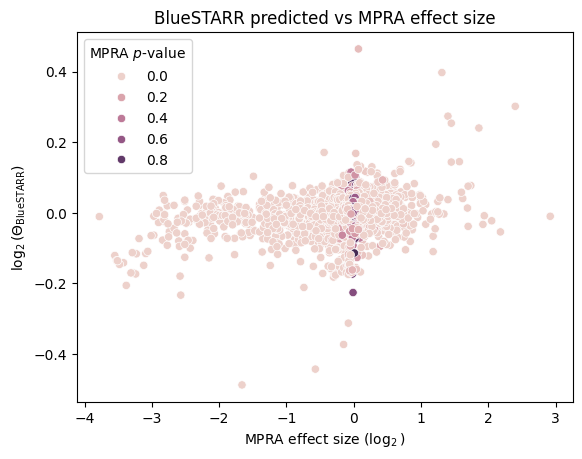

In [115]:
ax = sns.scatterplot(data=bk_df, x='mpra_max_log2effect', y='log2FC',
                     hue='mpra_p_value')
ax.set(xlabel='MPRA effect size ($\log_2)$', ylabel='$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
ax.set_title('BlueSTARR predicted vs MPRA effect size')
ax.legend(title='MPRA $p$-value')

Then the same removing this transition region.

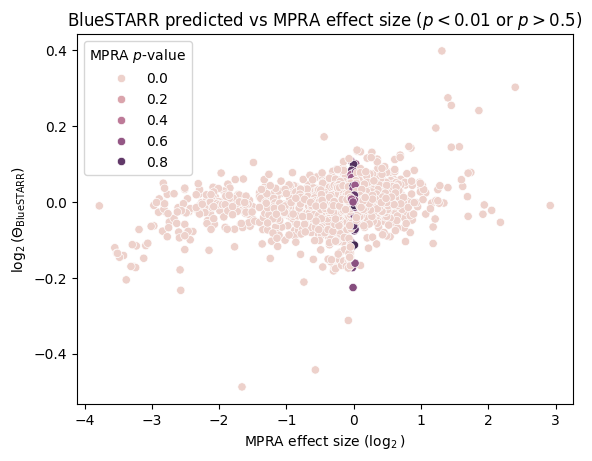

In [119]:
ax = sns.scatterplot(data=bk_df.loc[(bk_df['mpra_p_value'] < 0.01) | (bk_df['mpra_p_value'] > 0.5)],
                     x='mpra_max_log2effect', y='log2FC', hue='mpra_p_value')
ax.set(xlabel='MPRA effect size ($\log_2)$', ylabel='$\log_2(\Theta_{\mathrm{BlueSTARR}})$')
ax.set_title('BlueSTARR predicted vs MPRA effect size ($p < 0.01$ or $p > 0.5$)')
ax.legend(title='MPRA $p$-value')

## ROC display and AUC

### Define positive and negative classes

We define the positive class as variants with $P_{reg}$ greater than some threshold, and the negative class as variants with $P_{reg}$ less than some threshold.

In [126]:
Pval_pos = 0.01
Pval_neg = 0.2

In [127]:
pos_label = f"MPRA p < {Pval_pos}"
neg_label = f"MPRA p > {Pval_neg}"
bk_df['label'] = None
bk_df.loc[bk_df['mpra_p_value'] < Pval_pos, 'label'] = pos_label 
bk_df.loc[bk_df['mpra_p_value'] > Pval_neg, 'label'] = neg_label

### Subset predictions into those with positive and negative effects

In [128]:
bk_df_pos = bk_df.loc[bk_df['label'].notna() & (bk_df['mpra_max_log2effect'] > 0)]
bk_df_neg = bk_df.loc[bk_df['label'].notna() & (bk_df['mpra_max_log2effect'] < 0)]

How many positives and negatives do we have?

In [129]:
bk_df_pos.value_counts('label')

label
MPRA p < 0.01    997
MPRA p > 0.2     715
Name: count, dtype: int64

In [130]:
bk_df_neg.value_counts('label')

label
MPRA p < 0.01    1704
MPRA p > 0.2      769
Name: count, dtype: int64

### ROC curve display and AUC calculation


In [169]:
from sklearn.metrics import RocCurveDisplay, roc_curve, matthews_corrcoef

Text(0.5, 1.0, 'BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)')

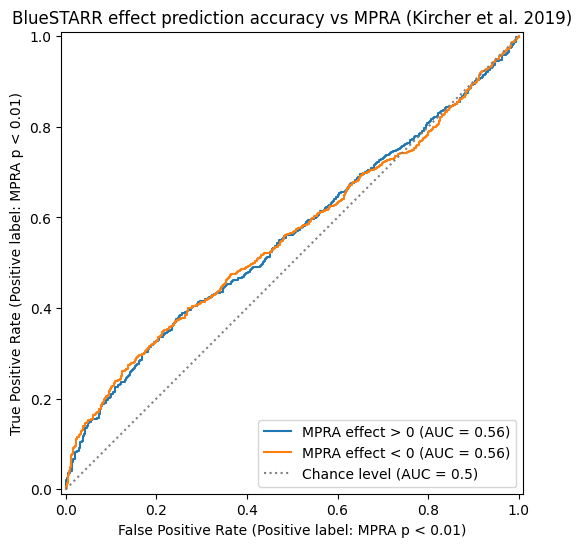

In [131]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_pos = RocCurveDisplay.from_predictions(
    bk_df_pos['label'],
    bk_df_pos['log2FC'], pos_label=pos_label,
    name='MPRA effect > 0', ax=ax)
roc_neg = RocCurveDisplay.from_predictions(
    bk_df_neg['label'],
    -bk_df_neg['log2FC'], pos_label=pos_label,
    name='MPRA effect < 0', ax=ax,
    plot_chance_level=True, chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'})
ax.set_title('BlueSTARR effect prediction accuracy vs MPRA (Kircher et al. 2019)')


### Matthew's Correlation Coefficient

The [Matthew's Correlation Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) (MCC), also known as Phi Coefficient, seems to be used in quite a few papers for reporting peformance against a benchmark.

To compute this, we need to decide on a decision boundary for the BlueSTARR predictions. We will determine the decision boundaries for the positive and negative effects, respectively, from [Youden's J statistic](https://en.wikipedia.org/wiki/Youden's_J_statistic) to find the threshold that maximizes the difference between TPR and FPR.

In [195]:
fpr_pos, tpr_pos, thresh_pos = roc_curve(bk_df_pos['label'], bk_df_pos['log2FC'], pos_label=pos_label)
fpr_neg, tpr_neg, thresh_neg = roc_curve(bk_df_neg['label'], -bk_df_neg['log2FC'], pos_label=pos_label)

In [196]:
log2FC_pos_cutoff = thresh_pos[np.argmax(tpr_pos - fpr_pos)]
log2FC_neg_cutoff = -thresh_neg[np.argmax(tpr_neg - fpr_neg)]
log2FC_pos_cutoff, log2FC_neg_cutoff

(0.0121952454501385, -0.0199425062781519)

In [197]:
mcc_pos = matthews_corrcoef(bk_df_pos['label'] == pos_label, bk_df_pos['log2FC'] >= log2FC_pos_cutoff)
mcc_neg = matthews_corrcoef(bk_df_neg['label'] == pos_label, bk_df_neg['log2FC'] <= log2FC_neg_cutoff)
print(f"MCC (MPRA effect > 0): {mcc_pos:.3f}")
print(f"MCC (MPRA effect < 0): {mcc_neg:.3f}")

MCC (MPRA effect > 0): 0.140
MCC (MPRA effect < 0): 0.149
